In [169]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [170]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [171]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [172]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect = True)

In [173]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [174]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [175]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [179]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(last_date)

one_year_ago = dt.date(2017,8,23) - dt.timedelta(days = 365)
print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
prcp_pull = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_pull, columns = ["date","Precipitation"])
prcp_df.set_index("date", inplace = True,)
prcp_df.head()

('2017-08-23',)
2016-08-23


,Precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


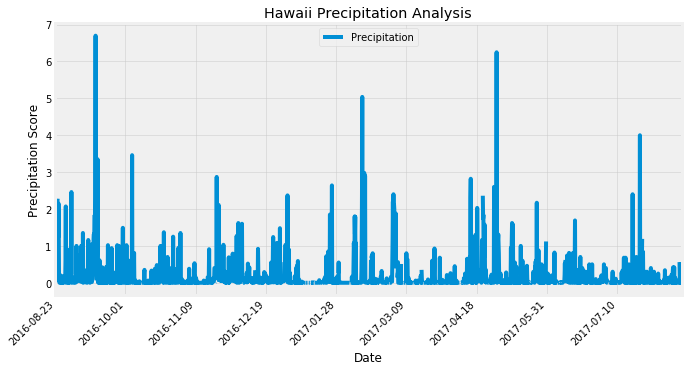

In [31]:
# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot(title = "Hawaii Precipitation Analysis", figsize = (10,5))
plt.grid(alpha = 0.5)
plt.legend(loc = "upper center")
plt.xlabel("Date")
plt.ylabel("Precipitation Score")
plt.xticks(rotation = 45, ha = "right")

plt.savefig("Images/precipitation.png", bbox_inches = "tight")
plt.show()

In [32]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [33]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(measurement.station).distinct().count()
station_count

9

In [67]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_summ = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

station_summ

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [69]:
#calculate the lowest, highest, and average temperature for the most active station

most_active = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first()


pull = [func.min(measurement.tobs), 
       func.max(measurement.tobs), 
       func.avg(measurement.tobs)]

most_active_tobs = session.query(*pull).\
    filter(measurement.station == most_active[0]).all()
most_active_tobs

[(54.0, 85.0, 71.66378066378067)]

In [147]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_hist = session.query(measurement.tobs).\
    filter(measurement.date >= one_year_ago).\
    filter(measurement.station == most_active[0]).\
    order_by(measurement.date).all()

most_active_hist_df = pd.DataFrame(most_active_hist, columns = ["tobs"])
most_active_hist_df.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


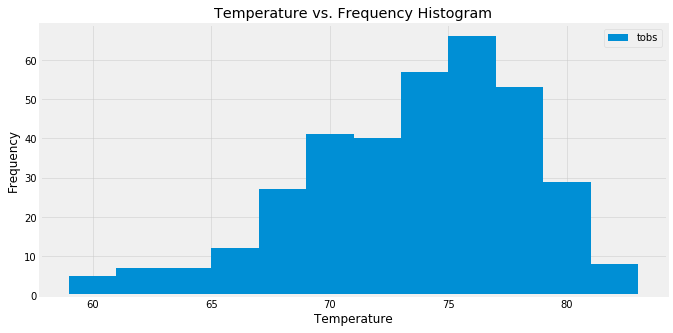

In [146]:
most_active_hist_df.plot.hist(bins = 12, title = "Temperature vs. Frequency Histogram", figsize = (10,5))
plt.grid(alpha = 0.5)
plt.xlabel("Temperature")
plt.legend(loc = "upper right")
plt.savefig("Images/temp_vs_freq.png", bbox_inches = "tight")
plt.show()

## Optional: Temperature Analysis II

In [99]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [94]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
#for your 3-15 day trip using the previous years' data for those same dates.

start_ly = "2017-03-14"
end_ly = "2017-03-28"

trip_ly = calc_temps(start_ly, end_ly)

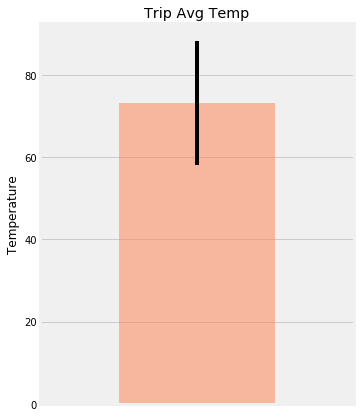

In [145]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_ly_df = pd.DataFrame(trip_ly, columns=["TMin", "TAvg", "TMax"])

trip_ly_df.plot.bar(y = "TAvg", yerr = (trip_ly_df["TMax"] - trip_ly_df["TMin"]), 
                    title="Trip Avg Temp", color = "coral", 
                    alpha = 0.5, figsize = (5,7), legend = None)

plt.xticks([])
plt.ylabel("Temperature")
plt.savefig("Images/trip_avg_temp.png", bbox_inches = "tight")
plt.show()

In [98]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(measurement.station, func.avg(measurement.prcp)).\
            filter(measurement.date.between(start_ly, end_ly)).\
            group_by(measurement.station).\
            order_by(func.avg(measurement.prcp).desc()).all()

[('USC00516128', 0.10461538461538461),
 ('USC00519281', 0.09000000000000001),
 ('USC00513117', 0.06333333333333334),
 ('USC00519523', 0.058),
 ('USC00517948', 0.03),
 ('USC00514830', 0.02625),
 ('USC00519397', 0.0013333333333333333)]

## Temperature Analysis III

In [126]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    Args:
        date(str): A date string in the format '%m-%d'
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    """
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [127]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`
from datetime import datetime
normals = []

# Set the start and end date of the trip
# Use the start and end date to create a range of dates
start_ly_conv = datetime.strptime(start_ly, '%Y-%m-%d')
end_ly_conv = datetime.strptime(end_ly, '%Y-%m-%d')

trip_dates = pd.date_range(start_ly_conv, end_ly_conv)

# Stip off the year and save a list of %m-%d strings
trip_dates = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
for trip_date in trip_dates:
    normals.append(*daily_normals(trip_date))
    
normals

[(62.0, 70.32758620689656, 77.0),
 (58.0, 68.54716981132076, 76.0),
 (60.0, 69.70370370370371, 78.0),
 (57.0, 68.54, 75.0),
 (57.0, 67.7843137254902, 76.0),
 (60.0, 69.1, 75.0),
 (62.0, 70.11764705882354, 80.0),
 (60.0, 71.07692307692308, 77.0),
 (65.0, 71.75471698113208, 77.0),
 (63.0, 70.79629629629629, 78.0),
 (62.0, 71.5, 77.0),
 (63.0, 71.5, 78.0),
 (64.0, 71.38, 80.0),
 (63.0, 71.53846153846153, 80.0),
 (59.0, 71.51785714285714, 82.0)]

In [132]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['TMin', 'TAvg', 'TMax'])

normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

normals_df

,TMin,TAvg,TMax
Date,,,
03-14,62.0,70.327586,77.0
03-15,58.0,68.547170,76.0
03-16,60.0,69.703704,78.0
03-17,57.0,68.540000,75.0
03-18,57.0,67.784314,76.0
03-19,60.0,69.100000,75.0
03-20,62.0,70.117647,80.0
03-21,60.0,71.076923,77.0
03-22,65.0,71.754717,77.0


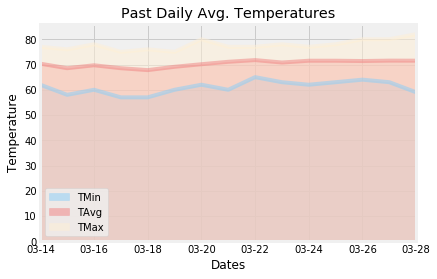

In [150]:
# Plot the daily normals as an area plot with `stacked=False`
colors = ['lightskyblue', 'lightcoral', 'papayawhip']

#make an area plot for the predicted temps
normals_df.plot(kind = 'area', stacked=False, alpha = 0.5, 
                color = colors, title = 'Past Daily Avg. Temperatures')

#make the labels
plt.xlabel('Dates')
plt.ylabel('Temperature')
plt.savefig("Images/past_avg_temp", bbox_inches = "tight")

plt.show()